In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
from scipy.misc import imread

In [21]:
%matplotlib inline

In [50]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import pandas as pd
import seaborn as sns

# Distributions
def CumExpDist(t,tau):
    return 1 - np.exp(-tau*t)
def SpatialExpDist(x,tau):
    return 1- np.exp(-tau*np.linalg.norm(x))

# Jump Map
def jump(x,t):
    mu = (x + 1*np.random.randn(1,2)).tolist()
    Sigma = [[5,0],[0,5]]
    return np.random.multivariate_normal(mu[0],Sigma)

# Hybrid Sys. Solver
def HDSint(max_events,t,fun,x0,mu,Sigma):
	event_counter = 0
	x_tot = [0,0,0]
	x_event = [0,0,0]
	x_reset = [0,0]
	C = [0,0,0]
	t_tot = []
	print('Progress:')
	while event_counter<max_events:
		sol = odeint(fun,x0,t)
		for i in range(len(sol)):
			P = multivariate_normal.pdf(sol[i],mu,Sigma)*CumExpDist(t[i],0.4)
			Event = np.random.binomial(1,P)
			if Event:
				flag = 1;
				x0 = jump(sol[i],t[i])
				x_event = np.vstack((x_event,np.hstack((sol[i],t[i]))))
				x_reset = np.vstack((x_reset,x0))
				break
		C = np.vstack((x_tot,np.hstack((sol[:i-1],t[:i-1].reshape(i-1,1)))))
		x_tot = np.vstack((x_tot,np.hstack((sol[:i],t[:i].reshape(i,1)))))
		if event_counter==0:
			t_tot = np.hstack((t_tot,t[:i])) 
		else:
			t_tot = np.hstack((t_tot,t[:i]+t_tot[-1]))
		if flag:
			flag = 0
			event_counter += 1
		else:
			x0 = sol[-1]
		if (100*event_counter)%(max_events*25)==0:
			print((100*event_counter)/max_events)
	return t_tot, x_tot[1:], x_event[1:], x_reset[1:], C[1:]

In [51]:
k = 2
b = 2
x0 = [5,0]
t = np.linspace(0,10,1000)
Sigma = np.array([[5,0],[0,5]])
mu = np.array([0,0])
#
def fun(xi,t):
    x = xi[0]
    v = xi[1]
    return [xi[1],-k*xi[0]-b*xi[1]]

In [63]:
#
#import PDMPsim
Ttot, Xtot, Xevent, Xreset, C = HDSint(500,t,fun,x0,mu,Sigma)

Progress:
25.0
50.0
75.0
100.0


Text(0.5,0,'t')

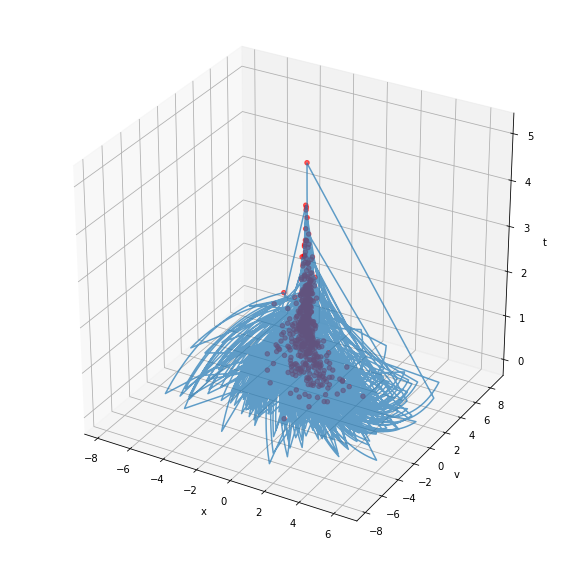

In [64]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection='3d')
ax.plot(xs = Xtot[:,0], ys = Xtot[:,1],zs = Xtot[:,2],alpha = 0.7)
ax.scatter(xs = Xevent[:,0], ys = Xevent[:,1],zs = Xevent[:,2],alpha = .6,color = 'red')
ax.set_xlabel('x')
ax.set_ylabel('v')
ax.set_zlabel('t')

In [65]:
def thin_flow_samples(C,N):
    tensor = torch.tensor(C)
    perm = torch.randperm(tensor.size(0))
    idx = perm[:N]
    return tensor[idx].numpy()


In [70]:
Ci = thin_flow_samples(C,len(Xevent))
# Create Labels
y1 = np.hstack((np.ones((Xevent.shape[0],1)),np.zeros((Xevent.shape[0],1))))
y2 = np.hstack((np.zeros((Ci.shape[0],1)),np.ones((Ci.shape[0],1))))
y = np.vstack((y1,y2))
# Create whole dataset
X = np.vstack((Xevent,Ci))

print(X.shape,y.shape)

from sklearn.model_selection import train_test_split
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42)

(1000, 3) (1000, 2)


In [82]:
#
bs = 1
import torch.utils.data as data_utils
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)
#
train = data_utils.TensorDataset(X_train,y_train)
train_loader = data_utils.DataLoader(train, batch_size=bs, shuffle=True)
#
test = data_utils.TensorDataset(X_test,y_test)
test_loader = data_utils.DataLoader(test, batch_size=bs, shuffle=True)

In [74]:
class NN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output = self.fc1(x)
        output = F.relu(output)
        output = self.out(output)
        return output

In [ ]:
# train_loader = torch.utils.data.DataLoader(
#         datasets.MNIST('mnist-data/', train=True, download=True,
#                        transform=transforms.Compose([transforms.ToTensor(),])),
#         batch_size=128, shuffle=True)

# test_loader = torch.utils.data.DataLoader(
#         datasets.MNIST('mnist-data/', train=False, transform=transforms.Compose([transforms.ToTensor(),])
#                        ),
#         batch_size=128, shuffle=True)

In [75]:
net = NN(3, 1024, 2)

In [76]:
import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [77]:
log_softmax = nn.LogSoftmax(dim=1)

In [78]:
def model(x_data, y_data):
    
    fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight))
    fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))
    
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight))
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias))
    
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,  'out.weight': outw_prior, 'out.bias': outb_prior}
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    lhat = log_softmax(lifted_reg_model(x_data))
    
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

In [79]:
softplus = torch.nn.Softplus()

def guide(x_data, y_data):
    
    # First layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)
    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(1)
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'out.weight': outw_prior, 'out.bias': outb_prior}
    
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()

In [80]:
optim = Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

In [83]:
num_iterations = 5
loss = 0

for j in range(num_iterations):
    loss = 0
    for batch_id, data in enumerate(train_loader):
        # calculate the loss and take a gradient step
        loss += svi.step(data[0].view(-1,3), data[1])
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = loss / normalizer_train
    
    print("Epoch ", j, " Loss ", total_epoch_loss_train)

Epoch  0  Loss  1360.111584760964
Epoch  1  Loss  126.44080385184289
Epoch  2  Loss  108.37522647023201
Epoch  3  Loss  114.09878887057305
Epoch  4  Loss  114.71890639662743


In [98]:
num_samples = 10
def predict(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(x).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    return np.argmax(mean.numpy(), axis=1)

print('Prediction when network is forced to predict')
correct = 0
total = 0
for j, data in enumerate(test_loader):
    images, labels = data
    predicted = predict(images.view(-1,3))
    total += labels.size(0)
    if predicted == [0]:
        predicted = torch.tensor([[1., 0.]])
    else:
        predicted = torch.tensor([[0., 1.]])
    correct += (predicted == labels).sum().item()
print("accuracy: %d %%" % (100 * correct / total))

Prediction when network is forced to predict
accuracy: 95 %


In [91]:
classes = ('D', 'C')

In [92]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    #plt.imshow(npimg,  cmap='gray')
    #fig.show(figsize=(1,1))
    
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.imshow(npimg,  cmap='gray', interpolation='nearest')
    plt.show()

In [94]:
num_samples = 100
def give_uncertainities(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [F.log_softmax(model(x.view(-1,3)).data, 1).detach().numpy() for model in sampled_models]
    return np.asarray(yhats)
    #mean = torch.mean(torch.stack(yhats), 0)
    #return np.argmax(mean, axis=1)

In [101]:
def test_batch(images, labels, plot=True):
    y = give_uncertainities(images)
    predicted_for_images = 0
    correct_predictions=0

    for i in range(len(labels)):
    
        if(plot):
            print("Real: ",labels[i].item())
            fig, axs = plt.subplots(1, 2, sharey=True,figsize=(20,2))
    
        all_digits_prob = []
    
        highted_something = False
    
        for j in range(len(classes)):
        
            highlight=False
        
            histo = []
            histo_exp = []
        
            for z in range(y.shape[0]):
                histo.append(y[z][i][j])
                histo_exp.append(np.exp(y[z][i][j]))
            
            prob = np.percentile(histo_exp, 50) #sampling median probability
        
            if(prob>0.2): #select if network thinks this sample is 20% chance of this being a label
                highlight = True #possibly an answer
        
            all_digits_prob.append(prob)
            
            if(plot):
            
                N, bins, patches = axs[j].hist(histo, bins=8, color = "lightgray", lw=0,  weights=np.ones(len(histo)) / len(histo), density=False)
                axs[j].set_title(str(j)+" ("+str(round(prob,2))+")") 
        
            if(highlight):
            
                highted_something = True
                
                if(plot):

                    # We'll color code by height, but you could use any scalar
                    fracs = N / N.max()

                    # we need to normalize the data to 0..1 for the full range of the colormap
                    norm = colors.Normalize(fracs.min(), fracs.max())

                    # Now, we'll loop through our objects and set the color of each accordingly
                    for thisfrac, thispatch in zip(fracs, patches):
                        color = plt.cm.viridis(norm(thisfrac))
                        thispatch.set_facecolor(color)

    
        if(plot):
            plt.show()
    
        predicted = np.argmax(all_digits_prob)
    
        if(highted_something):
            predicted_for_images+=1
            if(labels[i].item()==predicted):
                if(plot):
                    print("Correct")
                correct_predictions +=1.0
            else:
                if(plot):
                    print("Incorrect :()")
        else:
            if(plot):
                print("Undecided.")
        
        #if(plot):
            #imshow(images[i].squeeze())
        
    
    if(plot):
        print("Summary")
        print("Total images: ",len(labels))
        print("Predicted for: ",predicted_for_images)
        print("Accuracy when predicted: ",correct_predictions/predicted_for_images)
        
    return len(labels), correct_predictions, predicted_for_images 
    

In [100]:
# Prediction when network can decide not to predict

print('Prediction when network can refuse')
correct = 0
total = 0
total_predicted_for = 0
for j, data in enumerate(test_loader):
    images, labels = data
    
    total_minibatch, correct_minibatch, predictions_minibatch = test_batch(images, labels, plot=False)
    total += total_minibatch
    correct += correct_minibatch
    total_predicted_for += predictions_minibatch

print("Total images: ", total)
print("Skipped: ", total-total_predicted_for)
print("Accuracy when made predictions: %d %%" % (100 * correct / total_predicted_for))


Prediction when network can refuse


ValueError: only one element tensors can be converted to Python scalars

In [95]:
# preparing for evaluation
dataiter = iter(test_loader)
images, labels = dataiter.next()

In [96]:
test_batch(images[:100], labels[:100])

NameError: name 'test_batch' is not defined

In [ ]:
# generate random data

images_random = torch.rand(100,28,28)
labels_random = torch.randint(0,10, (100,))

In [ ]:
test_batch(images_random, labels_random)

In [ ]:
class data_loader(Dataset):
	def __init__(self, root):
		Images, Y = [], []
		folders = os.listdir(root)
		folders = folders[1:]

		for folder in folders:
            
			folder_path = os.path.join(root, folder)
			print(folder_path)
            
            
            
			for ims in os.listdir(folder_path):

				img_path = os.path.join(folder_path, ims)
				Images.append(np.array(imread(img_path)))
				Y.append(ord(folder) - 65)  # Folders are A-J so labels will be 0-9
				
		data = [(x, y) for x, y in zip(Images, Y)]
		self.data = data

	def __len__(self):
		return len(self.data)

	def __getitem__(self, index):
		img = self.data[index][0]

		# 8 bit images. Scale between 0, 1
		img = img.reshape(1, 28, 28) / 255

		# Input for Conv2D should be Channels x Height x Width
		img_tensor = transforms.ToTensor()(img).view(1, 28, 28).float()
		label = self.data[index][1]
		return (img_tensor, label)

In [ ]:
# NOT Mnist data

test_dataset_notmnist = data_loader('not-mnist')
test_loader_notmnist = DataLoader(test_dataset_notmnist, batch_size=128, shuffle=True)

In [ ]:
# Prediction when network can decide not to predict

print('Prediction on not-MNIST when network can refuse')
total = 0
total_predicted_for = 0
for j, data in enumerate(test_loader_notmnist):
    images, labels = data
    total_minibatch, correct_minibatch, predictions_minibatch = test_batch(images, labels, plot=False)
    total += total_minibatch
    total_predicted_for += predictions_minibatch

print("Total images: ", total)
print("Skipped: ", total-total_predicted_for)

In [ ]:
dataiter_notmnist = iter(test_loader_notmnist)
images_notmnist, labels_notmnist = dataiter_notmnist.next()

In [ ]:
test_batch(images_notmnist[:100], labels_notmnist[:100])